<a href="https://colab.research.google.com/github/smartyAe/My-all-data-science-learning-exercises-and-projects/blob/main/AnalyseEtNettoyageData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
data=pd.read_csv("operations.csv",parse_dates=[1,2])
data.head()

,identifiant_transaction,date_operation,date_valeur,libelle,debit,credit,solde
0,242,2023-10-06,2023-10-06,FORFAIT COMPTE SUPERBANK XX XX XX XX,-1.92,NaN,2513.79
1,25,2023-10-06,2023-10-06,CARTE XX XX CHEZ LUC XX,-10.00,NaN,2529.29
2,69,2023-10-06,2023-10-06,PRELEVEMENT XX TELEPHONE XX XX,-13.58,NaN,2515.71
3,299,2023-10-05,2023-10-05,CARTE XX XX XX XX XX XX,-10.64,NaN,2539.29
4,45,2023-10-05,2023-10-05,CARTE XX XX XX XX,-4.80,NaN,2549.93


In [ ]:
data.describe()

,identifiant_transaction,debit,credit,solde
count,308.000000,291.000000,17.000000,308.000000
mean,153.500000,-29.719691,560.775294,3516.345130
std,89.056162,74.201232,380.968935,641.625886
min,0.000000,-602.270000,1.600000,1613.210000
25%,76.750000,-21.265000,47.200000,3110.355000
50%,153.500000,-10.050000,676.000000,3534.345000
75%,230.250000,-4.195000,836.000000,3914.560000
max,307.000000,-0.800000,1071.600000,4802.700000


In [ ]:
data.columns = ['identifiant_transaction','date_operation','date_valeur',
                'libelle','debit','credit','solde']
data.head()

,identifiant_transaction,date_operation,date_valeur,libelle,debit,credit,solde
0,242,2023-10-06,2023-10-06,FORFAIT COMPTE SUPERBANK XX XX XX XX,-1.92,NaN,2513.79
1,25,2023-10-06,2023-10-06,CARTE XX XX CHEZ LUC XX,-10.00,NaN,2529.29
2,69,2023-10-06,2023-10-06,PRELEVEMENT XX TELEPHONE XX XX,-13.58,NaN,2515.71
3,299,2023-10-05,2023-10-05,CARTE XX XX XX XX XX XX,-10.64,NaN,2539.29
4,45,2023-10-05,2023-10-05,CARTE XX XX XX XX,-4.80,NaN,2549.93


In [ ]:
from collections import Counter

def most_common_words(labels):
    words = []
    for lab in labels:
        words += lab.split(" ")
    counter = Counter(words)
    for word in counter.most_common(100):
        print(word)

most_common_words(data['libelle'].values)

('XX', 1428)
('CARTE', 247)
('VIREMENT', 29)
('LES', 20)
('ANCIENS', 20)
('ROBINSON', 20)
('CHEZ', 16)
('LUC', 16)
('LA', 16)
("L'EPICERIE", 16)
('DEMBAS', 16)
('TOUPTIPRI', 12)
('CCNCF', 9)
('RETRAIT', 9)
('PRELEVEMENT', 8)
('RAPT', 8)
('FORFAIT', 7)
('COMPTE', 7)
('SUPERBANK', 7)
('TELEPHONE', 7)
('DON', 7)
('LOUVE', 7)
('PERMANENT', 6)
('LOYER', 6)
('VELOC', 4)


In [ ]:
CATEGS = {
    'LOYER': 'LOYER',
    'FORFAIT COMPTE SUPERBANK': 'COTISATION BANCAIRE',
    'LES ANCIENS ROBINSON': 'COURSES',
    "L'EPICERIE DENBAS": 'COURSES',
    'TELEPHONE': 'FACTURE TELEPHONE',
    'LA CCNCF': 'TRANSPORT',
    'CHEZ LUC': 'RESTAURANT',
    'RAPT': 'TRANSPORT',
    'TOUPTIPRI': 'COURSES',
    'LA LOUVE': 'COURSES',
    'VELOC': 'TRANSPORT'
}
TYPES = {
    'CARTE': 'CARTE',
    'VIR': 'VIREMENT',
    'VIREMENT': 'VIREMENT',
    'RETRAIT': 'RETRAIT',
    'PRLV': 'PRELEVEMENT',
    'DON': 'DON',
}

In [ ]:
EXPENSES = [80,200] # Bornes des catégories de dépense : petite, moyenne et grosse
LAST_BALANCE = 2400 # Solde du compte APRES la dernière opération en date
WEEKEND = ["Saturday","Sunday"] # Jours non travaillés

In [ ]:
# Controle des colonnes
for c in ['date_operation','libelle','debit','credit']:
    if c not in data.columns:
        if (c in ['debit','credit'] and 'montant' not in data.columns) or \
        (c not in ['debit','credit']):
            msg = "Il vous manque la colonne '{}'. Attention aux majuscules "
            msg += "et minuscules dans le nom des colonnes!"
            raise Exception(msg.format(c))

# Suppression des colonnes innutiles
for c in data.columns:
    if c not in ['date_operation','libelle','debit','credit','montant']:
        del data[c]

# Ajout de la colonne 'montant' si besoin
if 'montant' not in data.columns:
    data["debit"] = data["debit"].fillna(0)
    data["credit"] = data["credit"].fillna(0)
    data["montant"] = data["debit"] + data["credit"]
    del data["credit"], data["debit"]

# creation de la variable 'solde_avt_ope'
data = data.sort_values("date_operation")
amount = data["montant"]
balance = amount.cumsum()
balance = list(balance.values)
last_val = balance[-1]
balance = [0] + balance[:-1]
balance = balance - last_val + LAST_BALANCE
data["solde_avt_ope"] = balance

# Assignation des operations a une categorie et a un type
def detect_words(values, dictionary):
    result = []
    for lib in values:
        operation_type = "AUTRE"
        for word, val in dictionary.items():
            if word in lib:
                operation_type = val
        result.append(operation_type)
    return result
data["categ"] = detect_words(data["libelle"], CATEGS)
data["type"] = detect_words(data["libelle"], TYPES)

# creation des variables 'tranche_depense' et 'sens'
def expense_slice(value):
    value = -value # Les dépenses sont des nombres négatifs
    if value < 0:
        return "(pas une dépense)"
    elif value < EXPENSES[0]:
        return "petite"
    elif value < EXPENSES[1]:
        return "moyenne"
    else:
        return "grosse"
data["tranche_depense"] = data["montant"].map(expense_slice)
data["sens"] = ["credit" if m > 0 else "debit" for m in data["montant"]]

# Creation des autres variables
data["annee"] = data["date_operation"].map(lambda d: d.year)
data["mois"] = data["date_operation"].map(lambda d: d.month)
data["jour"] = data["date_operation"].map(lambda d: d.day)
data["jour_sem"] = data["date_operation"].map(lambda d: d.day_name)
data["jour_sem_num"] = data["date_operation"].map(lambda d: d.weekday()+1)
data["weekend"] = data["jour_sem"].isin(WEEKEND)
data["quart_mois"] = [int((jour-1)*4/31)+1 for jour in data["jour"]]
        
# Enregistrement au format CSV
data.to_csv("operations_enrichies.csv",index=False)

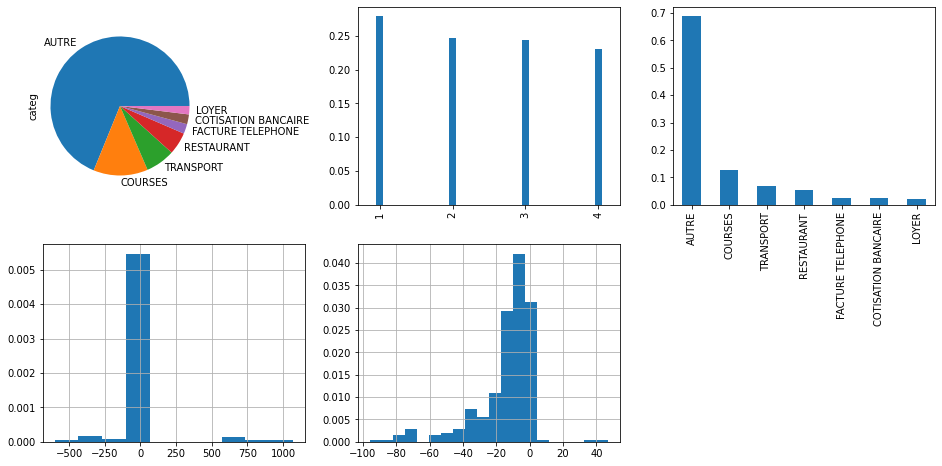

In [ ]:
import matplotlib.pyplot as plt

figure=plt.figure(figsize=(16,8))
plt.subplot(2,5,1)
# VARIABLE QUALITATIVE
# Diagramme en secteurs
data["categ"].value_counts(normalize=True).plot(kind='pie')
# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 


plt.subplot(2,3,3)
# Diagramme en tuyaux d'orgues
data["categ"].value_counts(normalize=True).plot(kind='bar')

plt.subplot(2,3,2)
# VARIABLE QUANTITATIVE
# Diagramme en bâtons
data["quart_mois"].value_counts(normalize=True).plot(kind='bar',width=0.1)

plt.subplot(2,3,4)
# Histogramme
data["montant"].hist(density=True)
plt.subplot(2,3,5)
# Histogramme plus beau
data[data.montant.abs() < 100]["montant"].hist(density=True,bins=20)
plt.show()

In [ ]:
effectifs=data["quart_mois"].value_counts()
modalite=effectifs.index
tab=pd.DataFrame(modalite,columns=["quart_mois"])
tab

,quart_mois
0,1
1,2
2,3
3,4


In [ ]:
tab["n"]=effectifs.values
tab

,quart_mois,n
0,1,86
1,2,76
2,3,75
3,4,71


In [ ]:
tab["f"]=tab["n"]/len(data)
tab

,quart_mois,n,f
0,1,86,0.279221
1,2,76,0.246753
2,3,75,0.243506
3,4,71,0.230519


In [ ]:
tab=tab.sort_values("quart_mois")
tab["F"]=tab["f"].cumsum()
tab

,quart_mois,n,f,F
0,1,86,0.279221,0.279221
1,2,76,0.246753,0.525974
2,3,75,0.243506,0.769481
3,4,71,0.230519,1.000000


----------------------------------------------------------------------------------------------------
AUTRE
moy sous-échantillon 23.433207547169832
median sous-échantillon -8.31
mode sous-échantillon 0   -1.6
dtype: float64
var sous-échantillon 40401.82999254187
std sous-échantillon 201.00206464746046
skew sous-échantillon 3.1215325222336427
kur sous-échantillon 12.716537970826296




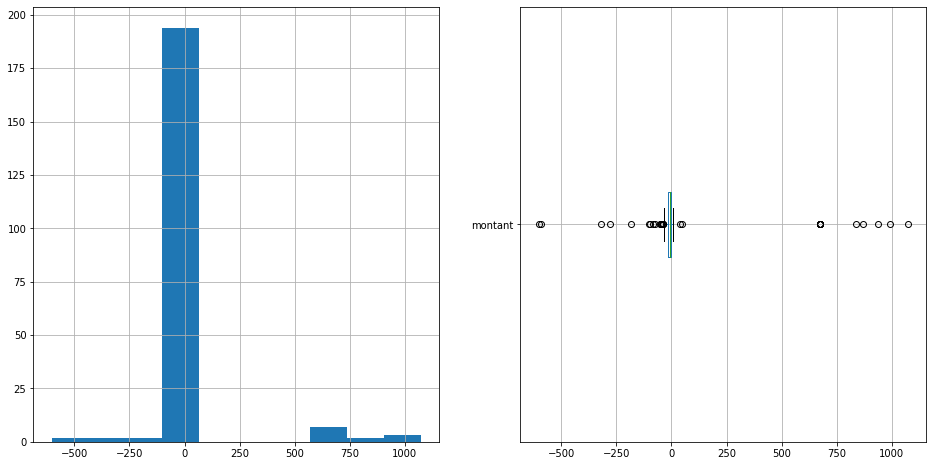

----------------------------------------------------------------------------------------------------
TRANSPORT
moy sous-échantillon -52.99714285714286
median sous-échantillon -53.1
mode sous-échantillon 0   -73.0
dtype: float64
var sous-échantillon 2205.016868027212
std sous-échantillon 46.95760713694014
skew sous-échantillon -1.248265076217821
kur sous-échantillon 2.1922705326917487




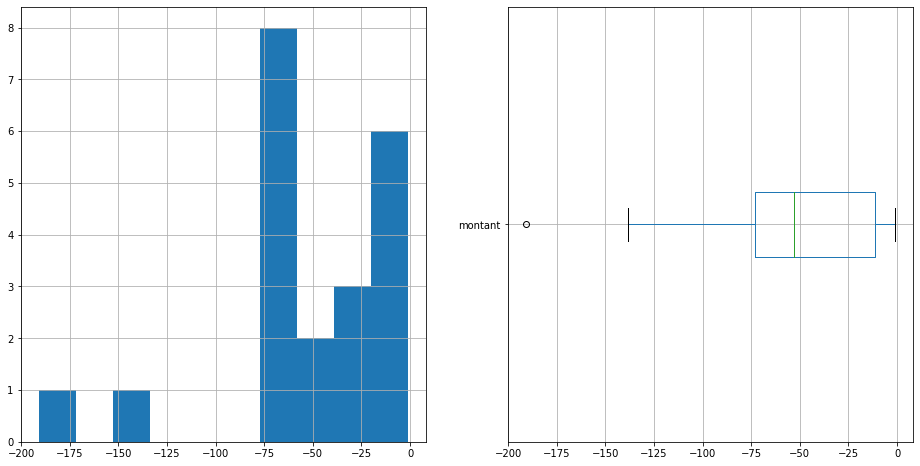

----------------------------------------------------------------------------------------------------
FACTURE TELEPHONE
moy sous-échantillon -12.045714285714283
median sous-échantillon -7.02
mode sous-échantillon 0   -7.02
1   -6.38
dtype: float64
var sous-échantillon 105.01905306122445
std sous-échantillon 10.247880417980317
skew sous-échantillon -2.3876514564281526
kur sous-échantillon 5.798563367885492




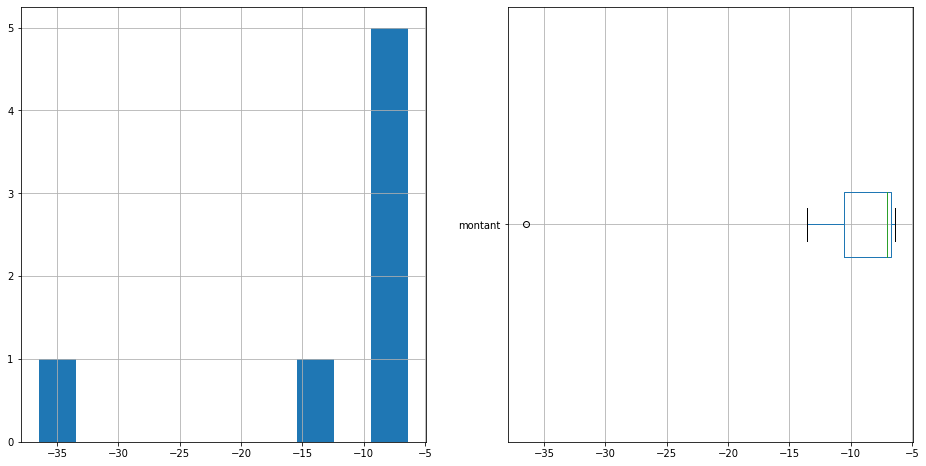

----------------------------------------------------------------------------------------------------
COURSES
moy sous-échantillon -16.341282051282054
median sous-échantillon -12.24
mode sous-échantillon 0    -60.16
1    -42.45
2    -42.42
3    -33.55
4    -32.67
5    -29.18
6    -28.11
7    -27.68
8    -26.58
9    -26.19
10   -23.43
11   -22.59
12   -21.73
13   -20.59
14   -18.45
15   -17.16
16   -13.59
17   -12.96
18   -12.49
19   -12.24
20   -10.91
21   -10.36
22    -9.88
23    -9.60
24    -9.31
25    -9.11
26    -6.89
27    -6.80
28    -6.60
29    -5.88
30    -4.63
31    -4.41
32    -4.39
33    -3.48
34    -2.93
35    -2.56
36    -2.51
37    -1.90
38    -0.94
dtype: float64
var sous-échantillon 177.0253547666009
std sous-échantillon 13.3050875520081
skew sous-échantillon -1.246748830645698
kur sous-échantillon 1.604730494087499




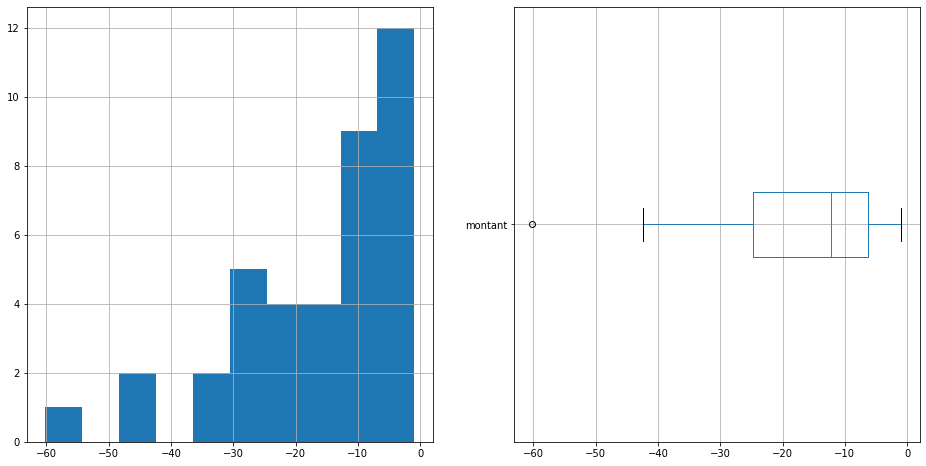

----------------------------------------------------------------------------------------------------
COTISATION BANCAIRE
moy sous-échantillon -1.8857142857142857
median sous-échantillon -1.92
mode sous-échantillon 0   -1.92
dtype: float64
var sous-échantillon 0.0015673469387755044
std sous-échantillon 0.03958973274443141
skew sous-échantillon 0.37416573867739106
kur sous-échantillon -2.800000000000003




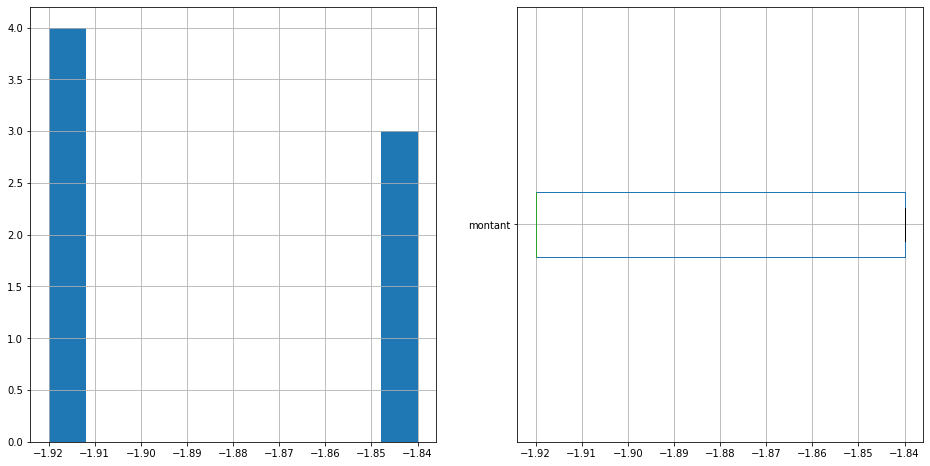

----------------------------------------------------------------------------------------------------
RESTAURANT
moy sous-échantillon -10.332500000000001
median sous-échantillon -10.1
mode sous-échantillon 0   -9.2
dtype: float64
var sous-échantillon 2.853193750000001
std sous-échantillon 1.689139943876765
skew sous-échantillon -0.8883503487158837
kur sous-échantillon 0.5988855591691937




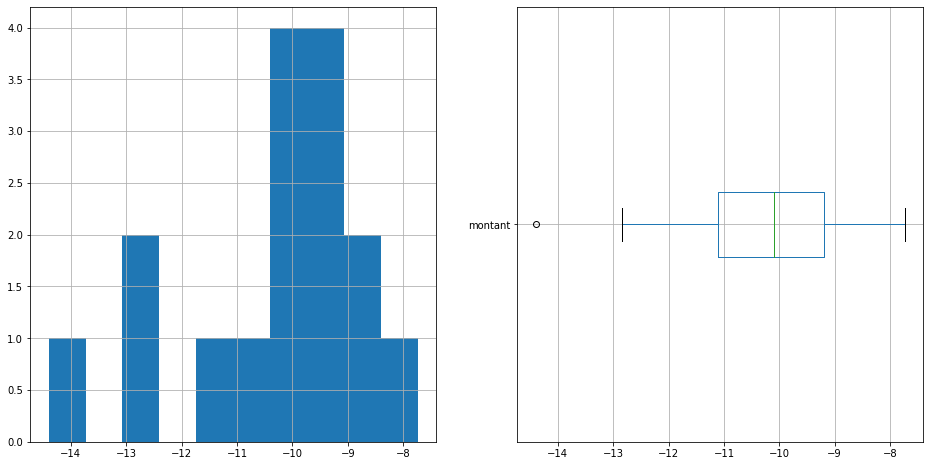

----------------------------------------------------------------------------------------------------
LOYER
moy sous-échantillon -345.0
median sous-échantillon -345.0
mode sous-échantillon 0   -345.0
dtype: float64
var sous-échantillon 0.0
std sous-échantillon 0.0
skew sous-échantillon 0
kur sous-échantillon 0




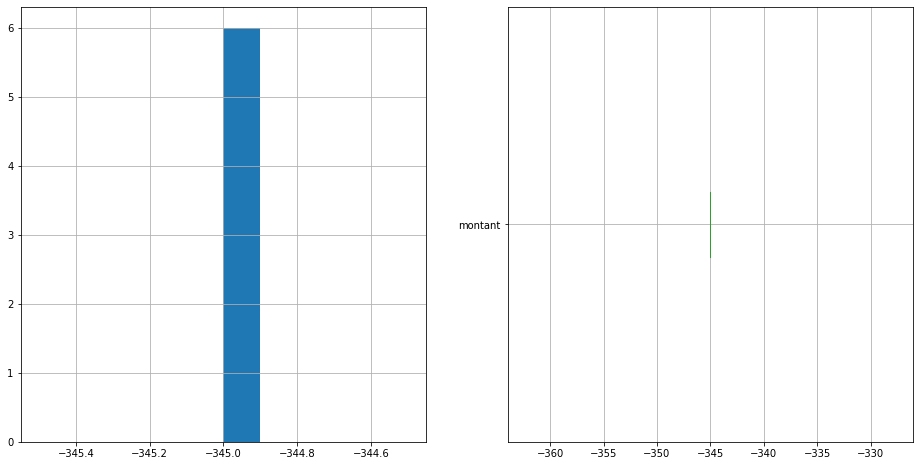

In [ ]:
for cat in data["categ"].unique():
  sous_echantillon=data[data.categ==cat]
  print("-"*100)
  print(cat)
  print("moy sous-échantillon",sous_echantillon["montant"].mean())
  print("median sous-échantillon",sous_echantillon["montant"].median())
  print("mode sous-échantillon",sous_echantillon["montant"].mode())
  print("var sous-échantillon",sous_echantillon["montant"].var(ddof=0))
  print("std sous-échantillon",sous_echantillon["montant"].std(ddof=0))
  print("skew sous-échantillon",sous_echantillon["montant"].skew())
  print("kur sous-échantillon",sous_echantillon["montant"].kurtosis())
  print("\n")
  fig=plt.figure(figsize=(16,8))
  plt.subplot(1,2,1)
  sous_echantillon["montant"].hist()
  plt.subplot(1,2,2)
  sous_echantillon.boxplot(column="montant",vert=False)
  plt.show()



# Nouvelle section